# Step 1: Data Acquisition

The primary objective of this section was to collect page view data for a specified subset of Wikipedia articles that are either about rare diseases or mention rare diseases. To achieve this, we utilized the Wikimedia Pageviews API which allows access to both desktop and mobile traffic data starting from July 2015 through the previous full month.

The data collection covered the following:

Desktop traffic

Mobile web traffic

Mobile app traffic

In [46]:
import requests
import json
import csv
import time
import datetime
import urllib.parse
from collections import defaultdict


Defining the API Endpoint and Headers:

We defined the API endpoint (https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article) and the necessary headers, including the user-agent for identifying the purpose of our request as research.

In [47]:
# Constants
API_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article'
HEADERS = {
    'User-Agent': '<your_email@example.com> Data Collection for Academic Research'
}
START_DATE = '20150701'  # YYYYMMDD format
END_DATE = datetime.datetime.now().strftime("%Y%m01")  # Up to the last full month

# Load the article data from your CSV file
file_path = '/Users/salahelbakri/Downloads/HW1/rare-disease_cleaned.AUG.2024.csv' 

def load_articles(filepath):
    articles = []
    with open(filepath, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        
        # Verify the column names
        if 'url' not in reader.fieldnames:
            raise KeyError(f"Expected 'url' column not found. Available columns: {reader.fieldnames}")
        
        for row in reader:
            try:
                # Extract the article title from the URL
                url = row['url']
                title = url.replace('https://en.wikipedia.org/wiki/', '')
                articles.append(title)
            except KeyError as e:
                print(f"Skipping row due to missing key: {e}")
    return articles

rare_disease_articles = load_articles(file_path)
print(f"Total articles loaded: {len(rare_disease_articles)}")



Total articles loaded: 1773


In [48]:
def get_pageviews(article_title, access, start_date, end_date):
    # Encode the article title to handle special characters
    encoded_title = urllib.parse.quote(article_title)
    url = f"{API_ENDPOINT}/en.wikipedia.org/{access}/user/{encoded_title}/monthly/{start_date}/{end_date}"
    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()  # Raise an error for bad responses
        data = response.json().get('items', [])
        # Remove the 'access' field as per instructions
        for item in data:
            item.pop('access', None)
        return data
    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 404:
            print(f"Article not found: {article_title}")
        else:
            print(f"HTTP error for {article_title}: {e}")
        return []
    except Exception as e:
        print(f"Error fetching data for {article_title}: {e}")
        return []


Making API Calls:

For each article in the list, the API was queried using three access types: desktop, mobile-web, and mobile-app. The API returned monthly pageview counts starting from July 2015 up until the last full month.

The API response was processed, and the access field was removed since it was not relevant for cumulative data. A throttle was applied to prevent overloading the API and ensure compliance with the Wikimedia Foundation’s API usage policy.

Combining Mobile Data:

Since mobile traffic is divided into two types (web and app), the two data streams were combined. For each month, the total mobile views were calculated by summing the views from mobile-web and mobile-app.

Timestamps were used to merge the two datasets for mobile access, and if either mobile-web or mobile-app views were missing for a given timestamp, a default value of zero was used.

In [49]:
# Dictionaries to hold the results for each dataset
data_desktop = defaultdict(dict)
data_mobile = defaultdict(dict)
data_cumulative = defaultdict(dict)

# Throttle API requests to avoid overloading the API
for index, article in enumerate(rare_disease_articles):
    print(f"Processing {index + 1}/{len(rare_disease_articles)}: {article}")
    
    # Get desktop data
    desktop_data = get_pageviews(article, 'desktop', START_DATE, END_DATE)
    
    # Get mobile web and mobile app data
    mobile_web_data = get_pageviews(article, 'mobile-web', START_DATE, END_DATE)
    mobile_app_data = get_pageviews(article, 'mobile-app', START_DATE, END_DATE)
    
    # Combine mobile web and mobile app data
    mobile_data = {}
    # Merge data based on timestamp
    timestamps = set([item['timestamp'] for item in mobile_web_data] + [item['timestamp'] for item in mobile_app_data])
    for ts in timestamps:
        web_views = next((item['views'] for item in mobile_web_data if item['timestamp'] == ts), 0)
        app_views = next((item['views'] for item in mobile_app_data if item['timestamp'] == ts), 0)
        total_mobile_views = web_views + app_views
        mobile_data[ts] = {'timestamp': ts, 'views': total_mobile_views}
    
    # Organize desktop data
    desktop_views = {item['timestamp']: {'timestamp': item['timestamp'], 'views': item['views']} for item in desktop_data}
    
    # Combine desktop and mobile data for cumulative views
    all_timestamps = set(list(desktop_views.keys()) + list(mobile_data.keys()))
    cumulative_data = {}
    for ts in all_timestamps:
        desktop_views_count = desktop_views.get(ts, {'views': 0})['views']
        mobile_views_count = mobile_data.get(ts, {'views': 0})['views']
        cumulative_views = desktop_views_count + mobile_views_count
        cumulative_data[ts] = {'timestamp': ts, 'views': cumulative_views}
    
    # Store data in dictionaries
    data_desktop[article] = list(desktop_views.values())
    data_mobile[article] = list(mobile_data.values())
    data_cumulative[article] = list(cumulative_data.values())
    
    # Delay between requests
    #time.sleep(1)  # Adjust delay as needed to comply with API terms


Processing 1/1773: Klinefelter_syndrome
Processing 2/1773: Aarskog–Scott_syndrome
Processing 3/1773: Abetalipoproteinemia
Processing 4/1773: MT-TP
Processing 5/1773: Ablepharon_macrostomia_syndrome
Processing 6/1773: Acanthocheilonemiasis
Processing 7/1773: Acanthosis_nigricans
Processing 8/1773: Aceruloplasminemia
Processing 9/1773: Megaesophagus
Processing 10/1773: Achard–Thiers_syndrome
Processing 11/1773: Achondrogenesis
Processing 12/1773: Achondroplasia
Processing 13/1773: Dwarfism
Processing 14/1773: Osteochondrodysplasia
Processing 15/1773: Fibroblast_growth_factor_receptor_3
Processing 16/1773: Vestibular_schwannoma
Processing 17/1773: Brain_tumor
Processing 18/1773: Acquired_generalized_lipodystrophy
Processing 19/1773: Barraquer–Simons_syndrome
Processing 20/1773: Acrodermatitis_enteropathica
Processing 21/1773: Zinc_deficiency
Processing 22/1773: Brown-Séquard_syndrome
Processing 23/1773: Spinal_cord_injury
Processing 24/1773: Brucellosis
Processing 25/1773: Yellowstone_Par

A cumulative dataset was generated for each article by summing the desktop and mobile views (both web and app) for each month. The timestamps from both the desktop and mobile data were used to synchronize the datasets, ensuring that the cumulative views reflect total user traffic for each article across all platforms.

The final datasets were saved in three separate JSON files:

Desktop Access: Contains monthly desktop traffic for each article

Filename: rare-disease_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json

Mobile Access: Contains the combined mobile traffic (web and app) for each article

Filename: rare-disease_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json

Cumulative Access: Contains the cumulative total of desktop and mobile traffic for each article.

Filename: rare-disease_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json

The format for these files ensures that each article's traffic data is stored as a time series, ordered by the timestamp, with the monthly record of user pageview requests for each article.

In [ ]:
# Define output file names
start_yyyymm = START_DATE[:6]
end_yyyymm = END_DATE[:6]

output_directory = '/Users/salahelbakri/Downloads/HW1'
# Save desktop data
with open(f'{output_directory}rare-disease_monthly_desktop_{start_yyyymm}-{end_yyyymm}.json', 'w', encoding='utf-8') as f:
    json.dump(data_desktop, f, ensure_ascii=False, indent=4)

# Save mobile data
with open(f'{output_directory}rare-disease_monthly_mobile_{start_yyyymm}-{end_yyyymm}.json', 'w', encoding='utf-8') as f:
    json.dump(data_mobile, f, ensure_ascii=False, indent=4)

# Save cumulative data
with open(f'{output_directory}rare-disease_monthly_cumulative_{start_yyyymm}-{end_yyyymm}.json', 'w', encoding='utf-8') as f:
    json.dump(data_cumulative, f, ensure_ascii=False, indent=4)

print("Data collection complete! Files saved.")


Data collection complete! Files saved.


# Step 2: Analysis

In this part of the project, we conducted a visual analysis of the collected Wikipedia page view data. Three distinct visualizations were produced using the time-series data to observe specific trends across the different access types (desktop and mobile). Below is a detailed description of each visualization and the corresponding steps taken to produce them.

In [65]:
# Function to calculate the average pageviews per article and exclude 0 view articles
def calculate_average_views(data):
    avg_views = {}
    for article, views in data.items():
        total_views = sum(item['views'] for item in views)
        avg_views[article] = total_views / len(views) if views else 0
    return avg_views

# Get the article with max views for mobile
max_mobile_article = max(avg_mobile, key=avg_mobile.get)

# Find the min mobile article that has views greater than 0
def find_min_article_with_views(avg_views):
    # Sort by views and find the first article with views greater than 0
    sorted_articles = sorted(avg_views.items(), key=lambda x: x[1])
    for article, avg_view in sorted_articles:
        if avg_view > 0:  # Select the first article with views greater than 0
            return article
    return None  # If no valid article is found

min_mobile_article = find_min_article_with_views(avg_mobile)

if min_mobile_article:
    print(f"Selected min mobile article: {min_mobile_article}, views: {avg_mobile[min_mobile_article]}")
else:
    print("No mobile articles found with positive views.")

# Function to find the minimum article with views greater than 0 for desktop
min_desktop_article = find_min_article_with_views(avg_desktop)

if min_desktop_article:
    print(f"Selected min desktop article: {min_desktop_article}, views: {avg_desktop[min_desktop_article]}")
else:
    print("No desktop articles found with positive views.")



Selected min mobile article: Filippi_Syndrome, views: 1.588235294117647
Selected min desktop article: Filippi_Syndrome, views: 3.6176470588235294


## Visualization 1: Maximum and Minimum Average Page Views

The objective of this visualization was to plot the time series of articles with the highest and lowest average page views for both desktop and mobile access. This resulted in four lines (max desktop, min desktop, max mobile, min mobile) representing the articles with the highest and lowest average page views across the entire time series.

Steps Taken:

Calculate Average Page Views:

For both desktop and mobile access, the average page views per article were calculated. Articles with an average page view count greater than zero were included in the analysis.
Find Max and Min Articles:

We identified the articles with the highest and lowest average page views for both desktop and mobile access.

Extract Time Series:

The page views for these max and min articles were extracted over time, ensuring that the timestamps were properly formatted (YYYYMM). Any malformed timestamps were corrected.

Plotting:

A plot was created with four lines: max desktop, min desktop, max mobile, and min mobile. The X-axis was formatted as months (YYYY/MM) and the Y-axis was log-scaled to represent the differences in page views.

Formatting:

Labels, legends, and gridlines were added to ensure clarity, and the plot was saved as a PNG file.

Output:

Filename: page_views_combined.png
Content: This plot showed the fluctuation of page views for the articles with the highest and lowest average page views for both desktop and mobile.

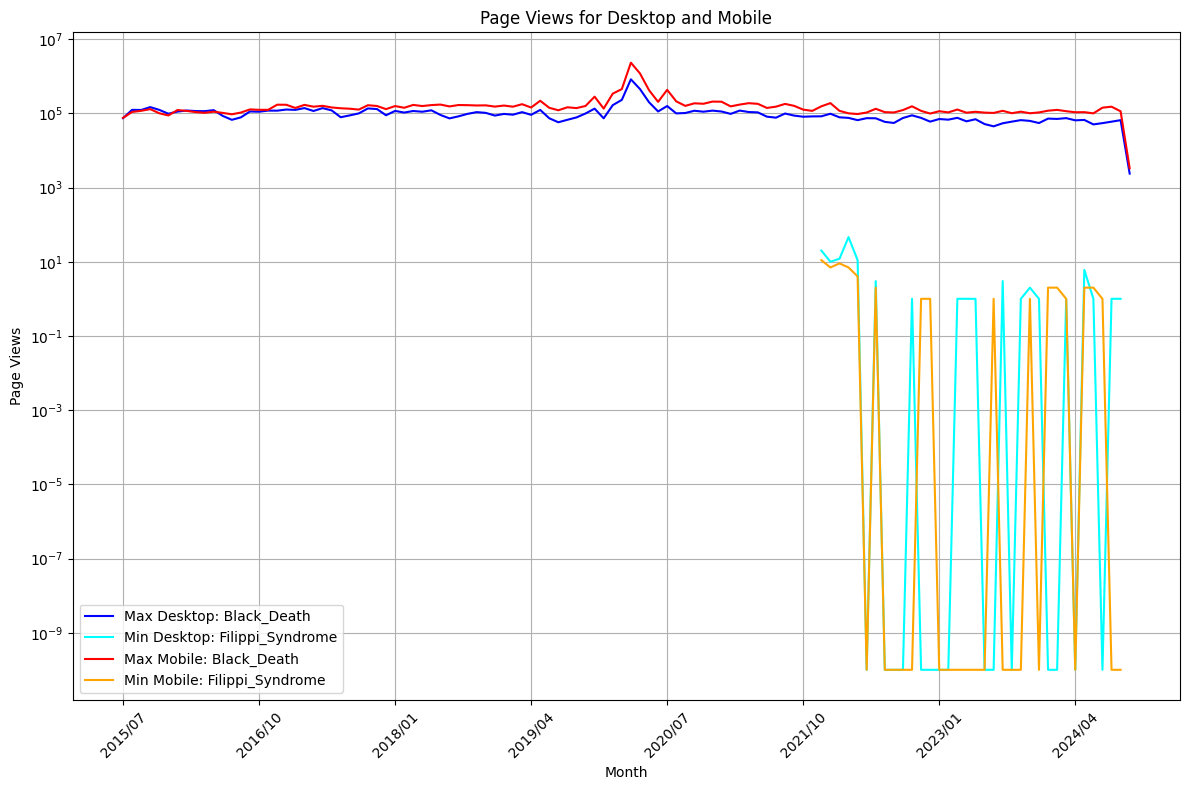

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to fix malformed timestamps
def fix_timestamp(timestamp):
    if timestamp.endswith('0'):
        return timestamp[:-1]
    return timestamp

# Function to extract and fix time series
def extract_time_series(data, article):
    valid_time_series = {}
    for item in data[article]:
        timestamp = fix_timestamp(item['timestamp'][:7])
        try:
            pd.to_datetime(timestamp, format='%Y%m', errors='raise')
            valid_time_series[timestamp] = item['views']
        except ValueError:
            print(f"Invalid timestamp found and skipped: {timestamp}")
    return valid_time_series

# Example usage for extracting time series
max_desktop_ts = extract_time_series(data_desktop, max_desktop_article)
min_desktop_ts = extract_time_series(data_desktop, min_desktop_article)
max_mobile_ts = extract_time_series(data_mobile, max_mobile_article)
min_mobile_ts = extract_time_series(data_mobile, min_mobile_article)

# Convert to DataFrames for easier plotting
df_max_desktop = pd.DataFrame(list(max_desktop_ts.items()), columns=['Month', 'Views']).set_index('Month')
df_min_desktop = pd.DataFrame(list(min_desktop_ts.items()), columns=['Month', 'Views']).set_index('Month')
df_max_mobile = pd.DataFrame(list(max_mobile_ts.items()), columns=['Month', 'Views']).set_index('Month')
df_min_mobile = pd.DataFrame(list(min_mobile_ts.items()), columns=['Month', 'Views']).set_index('Month')

# Convert the index to datetime and format the X-axis as YYYY/MM
df_max_desktop.index = pd.to_datetime(df_max_desktop.index, format='%Y%m').strftime('%Y/%m')
df_min_desktop.index = pd.to_datetime(df_min_desktop.index, format='%Y%m').strftime('%Y/%m')
df_max_mobile.index = pd.to_datetime(df_max_mobile.index, format='%Y%m').strftime('%Y/%m')
df_min_mobile.index = pd.to_datetime(df_min_mobile.index, format='%Y%m').strftime('%Y/%m')

# Replace zero or negative values with a small positive number
df_max_desktop['Views'] = df_max_desktop['Views'].apply(lambda x: x if x > 0 else 1e-10)
df_min_desktop['Views'] = df_min_desktop['Views'].apply(lambda x: x if x > 0 else 1e-10)
df_max_mobile['Views'] = df_max_mobile['Views'].apply(lambda x: x if x > 0 else 1e-10)
df_min_mobile['Views'] = df_min_mobile['Views'].apply(lambda x: x if x > 0 else 1e-10)

# Create a single DataFrame for plotting
df_combined = pd.DataFrame({
    'Max Desktop': df_max_desktop['Views'],
    'Min Desktop': df_min_desktop['Views'],
    'Max Mobile': df_max_mobile['Views'],
    'Min Mobile': df_min_mobile['Views']
})

# Plotting the data
plt.figure(figsize=(12, 8))

# Plot max and min desktop
plt.plot(df_combined.index, df_combined['Max Desktop'], label=f'Max Desktop: {max_desktop_article}', color='blue')
plt.plot(df_combined.index, df_combined['Min Desktop'], label=f'Min Desktop: {min_desktop_article}', color='cyan')

# Plot max and min mobile
plt.plot(df_combined.index, df_combined['Max Mobile'], label=f'Max Mobile: {max_mobile_article}', color='red')
plt.plot(df_combined.index, df_combined['Min Mobile'], label=f'Min Mobile: {min_mobile_article}', color='orange')

# Formatting the plot
plt.title('Page Views for Desktop and Mobile')
plt.xlabel('Month')
plt.ylabel('Page Views')
plt.xticks(rotation=45)

# Set x-axis ticks with MaxNLocator to space them out
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins='auto', prune='both'))

plt.yscale('log')  # Logarithmic Y-axis for page views
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig('/Users/salahelbakri/Downloads/HW1/page_views_combined.png')
plt.show()


# Visualization 2: Top 10 Peak Page Views

The goal of this visualization was to display the time series for the top 10 articles by their peak page views. Both desktop and mobile access types were considered, resulting in 20 lines (10 for desktop, 10 for mobile).

Steps Taken:

Find Peak Page Views:
For each article, the month with the highest (peak) page views was identified. This was done separately for desktop and mobile access.

Select Top 10 Articles:
The articles with the top 10 peak page views for both desktop and mobile were selected based on the identified peak values.

Extract Time Series:
The page views for the selected top articles were extracted over time, ensuring that the timestamps were properly formatted (YYYYMM).

Plotting:
A plot was created with 20 lines representing the top 10 articles for both desktop and mobile. The X-axis was formatted as months (YYYY/MM) and the Y-axis was log-scaled for better visibility of differences in page views.

Formatting:
Legends, titles, and gridlines were added, and the plot was saved as a PNG file.

Output:
Filename: top_peak_pageviews.png
Content: This plot displayed the time series of the articles with the highest peak page views for both desktop and mobile access.

Current index values for desktop:
Index(['2015070', '2015080', '2015090', '2015100', '2015110', '2015120',
       '2016010', '2016020', '2016030', '2016040',
       ...
       '2024010', '2024020', '2024030', '2024040', '2024050', '2024060',
       '2024070', '2024080', '2024090', '2024100'],
      dtype='object', length=112)
Current index values for mobile:
Index(['2022060', '2016100', '2023010', '2019110', '2016030', '2016020',
       '2022010', '2022030', '2023020', '2023040',
       ...
       '2023090', '2024060', '2024030', '2022080', '2023110', '2016060',
       '2023080', '2017070', '2024040', '2017060'],
      dtype='object', length=112)


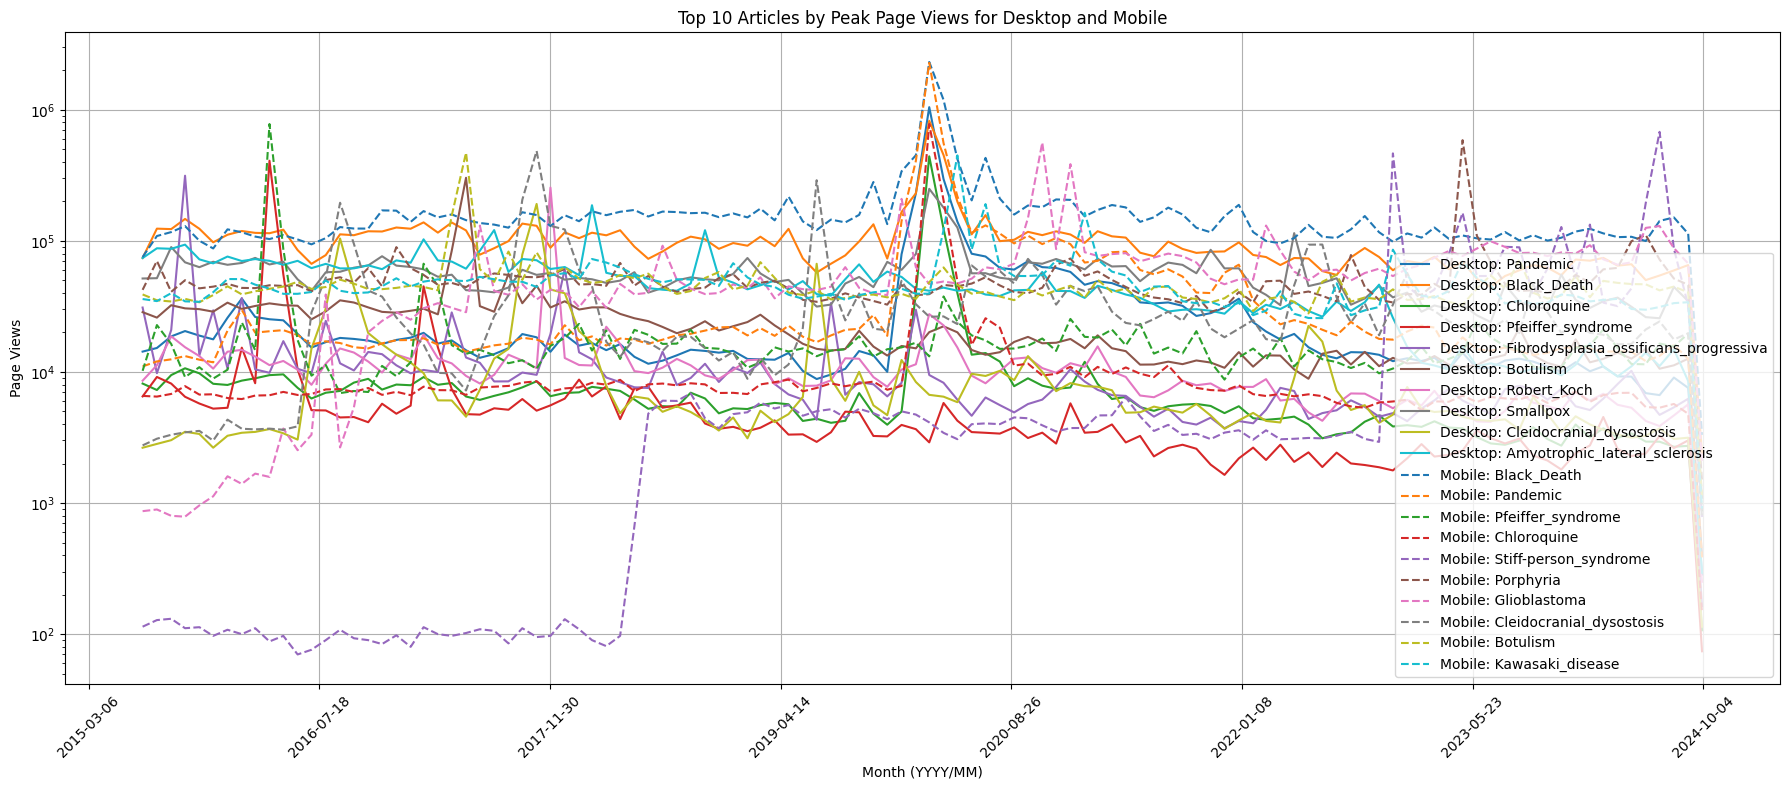

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to extract time series data and find peak page views
def extract_peak_time_series(data):
    peak_time_series = {}
    for article in data.keys():
        # Extract the month and views into a list
        views_data = [(item['timestamp'][:7], item['views']) for item in data[article] if item['views'] > 0]
        if views_data:
            # Find the month with peak views
            peak_views = max(views_data, key=lambda x: x[1])
            peak_time_series[article] = peak_views[1]  # Store peak views for each article
    return peak_time_series

# Get the peak page views for desktop and mobile
peak_desktop = extract_peak_time_series(data_desktop)
peak_mobile = extract_peak_time_series(data_mobile)

# Combine and get top 10 articles by peak views
top_peak_desktop = sorted(peak_desktop.items(), key=lambda x: x[1], reverse=True)[:10]
top_peak_mobile = sorted(peak_mobile.items(), key=lambda x: x[1], reverse=True)[:10]

# Prepare for time series extraction
top_desktop_articles = [article for article, _ in top_peak_desktop]
top_mobile_articles = [article for article, _ in top_peak_mobile]

# Function to extract time series for the top articles
def extract_time_series_for_top(data, top_articles):
    time_series_data = {}
    for article in top_articles:
        time_series_data[article] = {item['timestamp'][:7]: item['views'] for item in data[article] if item['views'] > 0}
    return time_series_data

# Get time series data for the top articles
time_series_top_desktop = extract_time_series_for_top(data_desktop, top_desktop_articles)
time_series_top_mobile = extract_time_series_for_top(data_mobile, top_mobile_articles)

# Convert to DataFrames for plotting
df_top_desktop = pd.DataFrame(time_series_top_desktop).fillna(0)
df_top_mobile = pd.DataFrame(time_series_top_mobile).fillna(0)

# Convert the index to datetime to ensure proper ordering
try:
    # Inspect the index to find problematic entries
    print("Current index values for desktop:")
    print(df_top_desktop.index.unique())
    
    # Fixing the format by slicing the last character
    df_top_desktop.index = df_top_desktop.index.str.slice(0, 6)  # Keep only 'YYYYMM'
    df_top_desktop.index = pd.to_datetime(df_top_desktop.index, format='%Y%m')

    print("Current index values for mobile:")
    print(df_top_mobile.index.unique())
    
    # Fixing the format by slicing the last character
    df_top_mobile.index = df_top_mobile.index.str.slice(0, 6)  # Keep only 'YYYYMM'
    df_top_mobile.index = pd.to_datetime(df_top_mobile.index, format='%Y%m')

except ValueError as e:
    print("Error converting index to datetime:", e)
    
# Sort the DataFrames by the index (date)
df_top_desktop.sort_index(inplace=True)
df_top_mobile.sort_index(inplace=True)

# Plotting the data
plt.figure(figsize=(18, 8))

# Plot the top articles for desktop
for article in df_top_desktop.columns:
    plt.plot(df_top_desktop.index, df_top_desktop[article], label=f'Desktop: {article}')

# Plot the top articles for mobile
for article in df_top_mobile.columns:
    plt.plot(df_top_mobile.index, df_top_mobile[article], label=f'Mobile: {article}', linestyle='--')

# Formatting the plot
plt.title('Top 10 Articles by Peak Page Views for Desktop and Mobile')
plt.xlabel('Month (YYYY/MM)')
plt.ylabel('Page Views')
plt.xticks(rotation=45)

# Set x-axis ticks with MaxNLocator to space them out
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins='auto', prune='both'))

plt.yscale('log')  # Logarithmic Y-axis for page views
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()

# Save and show the plot
plt.savefig('/Users/salahelbakri/Downloads/HW1/top_peak_pageviews.png')
plt.show()


# Visualization 3: Fewest Months of Data

The third visualization focused on identifying and displaying the time series of articles with the fewest months of available data. This helped in understanding articles that were either newer or had irregular data over time.

Steps Taken:

Find Fewest Months:
For each article, we counted the number of months where there were valid page view data points. This was done separately for desktop and mobile access.

Select Top 10 Articles:
The top 10 articles with the fewest months of data were selected for both desktop and mobile access.

Extract Time Series:
The page views for these selected articles were extracted over time, ensuring that the timestamps were properly formatted (YYYYMM).

Plotting:
A plot was created showing the time series for the selected articles. Since this visualization focuses on the presence of data over time rather than the actual values of page views, the Y-axis was log-scaled but the emphasis was on the X-axis representing the timeline.

Formatting:
The X-axis was labeled and spaced out to represent the time series more clearly. Legends and gridlines were added, and the plot was saved as a PNG file.

Output:
Filename: fewest_months_pageviews.png
Content: This plot displayed the time series for the top 10 articles with the fewest months of available data, for both desktop and mobile access.

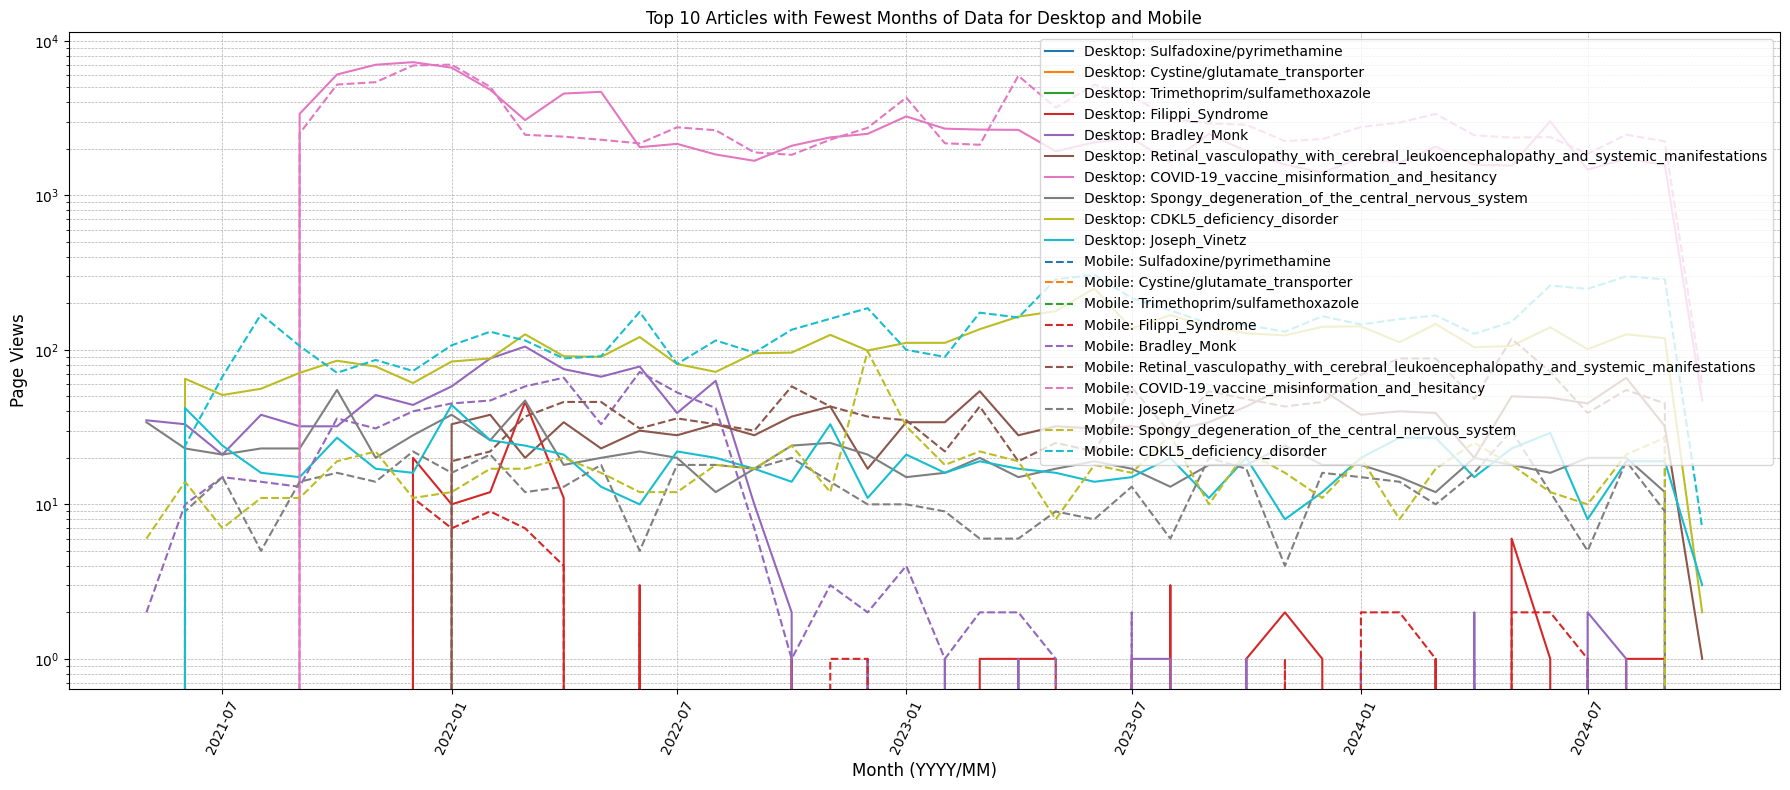

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to find the articles with the fewest months of data
def find_fewest_months(data, num_articles=10):
    months_of_data = {}
    for article, views in data.items():
        months_with_data = [item['timestamp'][:7] for item in views if item['views'] > 0]
        months_of_data[article] = len(set(months_with_data))  # Count unique months with data
    
    # Sort articles by fewest months and select top num_articles
    fewest_months = sorted(months_of_data.items(), key=lambda x: x[1])[:num_articles]
    return [article for article, _ in fewest_months]

# Get the top 10 articles with the fewest months of data for desktop and mobile
fewest_months_desktop = find_fewest_months(data_desktop)
fewest_months_mobile = find_fewest_months(data_mobile)

# Extract the time series for these articles
def extract_time_series_for_fewest(data, fewest_articles):
    time_series_data = {}
    for article in fewest_articles:
        time_series_data[article] = {item['timestamp'][:7]: item['views'] for item in data[article] if item['views'] > 0}
    return time_series_data

# Get time series data for the fewest months articles
time_series_fewest_desktop = extract_time_series_for_fewest(data_desktop, fewest_months_desktop)
time_series_fewest_mobile = extract_time_series_for_fewest(data_mobile, fewest_months_mobile)

# Convert to DataFrames for plotting
df_fewest_desktop = pd.DataFrame(time_series_fewest_desktop).fillna(0)
df_fewest_mobile = pd.DataFrame(time_series_fewest_mobile).fillna(0)

# Convert the index to datetime to ensure proper ordering
try:
    # Keep only 'YYYYMM'
    df_fewest_desktop.index = df_fewest_desktop.index.str.slice(0, 6)
    df_fewest_desktop.index = pd.to_datetime(df_fewest_desktop.index, format='%Y%m')

    df_fewest_mobile.index = df_fewest_mobile.index.str.slice(0, 6)
    df_fewest_mobile.index = pd.to_datetime(df_fewest_mobile.index, format='%Y%m')

except ValueError as e:
    print("Error converting index to datetime:", e)

# Sort the DataFrames by the index (date)
df_fewest_desktop.sort_index(inplace=True)
df_fewest_mobile.sort_index(inplace=True)

# Plotting the data
plt.figure(figsize=(18, 8))

# Plot the articles with fewest months of data for desktop
for article in df_fewest_desktop.columns:
    plt.plot(df_fewest_desktop.index, df_fewest_desktop[article], label=f'Desktop: {article}')

# Plot the articles with fewest months of data for mobile
for article in df_fewest_mobile.columns:
    plt.plot(df_fewest_mobile.index, df_fewest_mobile[article], label=f'Mobile: {article}', linestyle='--')

# Formatting the plot
plt.title('Top 10 Articles with Fewest Months of Data for Desktop and Mobile')
plt.xlabel('Month (YYYY/MM)', fontsize=12)
plt.ylabel('Page Views', fontsize=12)
plt.xticks(rotation=65, fontsize=10)
plt.yticks(fontsize=10)

# Set the y-axis to log scale
plt.yscale('log')

# Add a legend
plt.legend(loc='upper right', fontsize=10)

# Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('/Users/salahelbakri/Downloads/HW1/fewest_months_pageviews.png', format='png')
plt.show()
